# Introdução

Nessa etapa devemos analisar os dados de produtos. A análise irá se dividir em
duas. Em ambas serão exploradas a relação dos atributos com a variável
`category`, que desejamos prever. Na primeira, os dados numéricos vão ser
analisados. Na segunda parte os dados textuais serão explorados. Para o caso
dos dados textuais, será necessária antes uma etapa de processamento NLP. Isso
envolve: limpeza, tokenização, vetorização e modelagem de tópicos. Com isso,
teremos um número consiso de variáveis que representam padrões textuais e que
podem ser mais facilmente utilizada para identificar padrões de associação com
a variável alvo.

O principal objetivo desse notebook, é ao analisar descritivamente os dados,
encontrar atributos úteis para a modelagem da variável categócia. Mais que 
apenas encontrar e desenvolver features para a modelagem, é importante nessa
etapa aumentar a compreensão sobre os dados para que na etapa de modelagem
consigamos explicar a utilização dos dados e seus potenciais impactos na
previsão das categorias de produtos.

# Imports

In [1]:
# imports gerais de plotagem e manipulação de dados
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# utilidade
from IPython.display import display

# imports de préprocessamento NLP (tokenização e limpeza dos textos)
import nltk
import unicodedata
import re
import string

# imports de vectorização e modelagem de tópicos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

Baixando as dependências dos modelos de NLP

In [2]:
# listas de stopwords
nltk.download('stopwords')
# tokenização
nltk.download('punkt')
# stemming
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leona\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leona\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\leona\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# Carregando os dados de produtos

Vamos carregar apenas os dados de produto de treinamento para essa análise
exploratória.

In [3]:
df = pd.read_pickle("../data/train_prod.pickle")
df.head()

,seller_id,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
product_id,,,,,,,,,,,
7010568,761717,Caneta Personalizada Barquinho,caneta personalizada canetas personalizadas pa...,2017-07-12 16:29:08,12.260,15.0,0,30.0,116.0,11.0,Lembrancinhas
6957815,3708390,Toalha Bordada Madrinha de Consagração,toalhas lavabo lembrancinhas batizado toalha c...,2016-12-08 10:40:28,28.490,7.5,1,4.5,463.0,8.5,Lembrancinhas
10378129,8225602,Colar Best Friends Folheado 4 Partes.,biju best friends mirella flavia gabi,2017-01-24 14:32:48,40.290,13.0,0,0.0,9183.0,157.0,Bijuterias e Jóias
4658013,7043431,Azulejo Certificado Melhor Pai do Mundo,dia pais azulejos,2019-06-14 16:09:23,39.220,338.0,0,1.0,77.5,12.0,Decoração
487440,1408350,Mochila saco bailarina soldadinho de chumbo,sacolinhas festa bailarina lembrancinhas baila...,2018-02-21 16:39:27,13.175,12.5,1,32.0,1484.5,0.0,Lembrancinhas


# Análise descritiva dos dados

Essa análise se dividirá em duas partes. Na primeira iremos utilizar as
variáveis **numéricas** e **categóricas** e na segunda as **variáveis textuais**.
O que distingue essas duas partes, é a quantidade de pré-processamento necessário
para a utilização dos dados. No caso das variáveis numéricas e categóricas,
pouca ou nenhuma transformação precisa ser realizada para que conseguimos
identificar potenciais relações com a variável explicada. Já no caso das
variáveis textuais (`title` e `concatenated_tags`) é necessário incorrer em
etapas de pré-processamento NLP e técnicas de redução de dimensionalidade para
que seja possível analisar os dados.

## Variáveis numéricas e categóricas

Nessa parte serão analisadas as seguintes variáveis:
- categóricas: `express_delivery`
- data: `creation_date`
- numéricas: `price` | `weight` | `minimum_quantity` | `order_counts` |
`view_counts`

No caso da existência de entrega expressa, vamos que algumas categorias tem uma
proporção bem maior que as outras. Por exemplo, quase todos os produtos do tipo
 **Lembrancinhas**, possuem entrega expressa. No outro lado, temos categorias
em que a proporção de entregas que não são expressas são maiores,
**Bijuterias e Jóias** e **Outros**. Porém nesses casos, a diferença não é tão
expressiva.

Pela distribuição das categorias entre os tipos de tipos de entrega, parece que
o tipo de entrega pode ser mais útil para identificar as **Lembrancinhas**,
apesar de ainda parecer ser útil para os casos de **Decoração**.

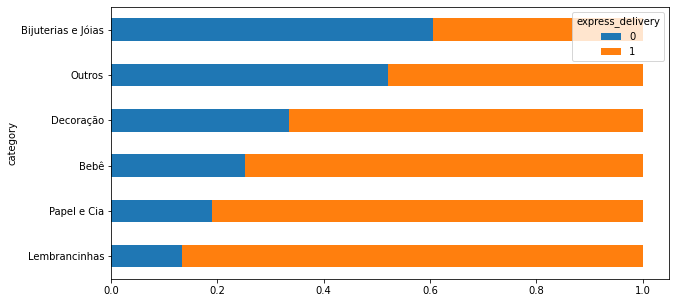

In [4]:
deliv_cat_cross = pd.crosstab(df["category"], df["express_delivery"])
(deliv_cat_cross.div(deliv_cat_cross.sum(axis=1), axis=0).
 sort_values(0).
 plot(kind="barh", stacked=True, figsize=(10, 5)))
plt.show()

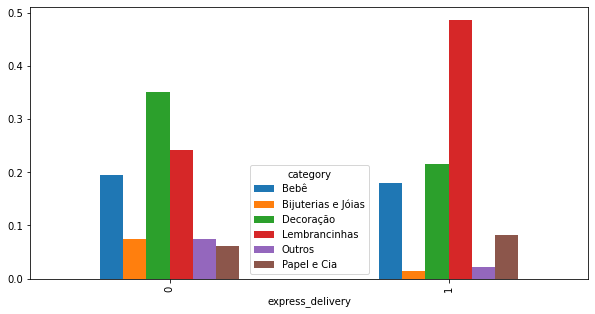

In [5]:
deliv_cat_cross = pd.crosstab(df["express_delivery"], df["category"])
(deliv_cat_cross.div(deliv_cat_cross.sum(axis=1), axis=0).
 plot(kind="bar", figsize=(10, 5)))
plt.show()

No caso das séries temporais, aparenetemente não há uma padrão que diferencia
a evolução da quantidade de produtos por `creation_date` (em anos) com excessão
de uma diferença de escala. 

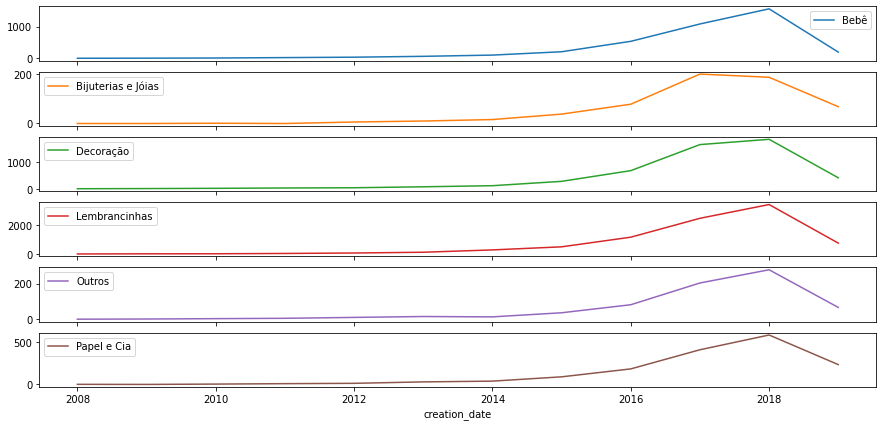

In [6]:
(df.groupby([df["creation_date"].dt.year, df["category"]]).
 size().reset_index().
 pivot(index="creation_date", columns="category", values=0).fillna(0).
 plot(subplots=True, figsize=(15, 7)))
plt.show()

Para as variáveis númericas, vamos fazer dois tipos de análise. Na primeira,
a partir de uma tabela com estatísticas descritivas de dispersão e tendência
central por categorias. A segunda análise será gráfica, utilizando a função
`pairplot` do `seaborn`. Enquanto que na primeira nos concentramos em cada
variável em separado, na segunda análise conseguimos explorar a relação da
interação par a par de cada variável explicativa com a variável explicada
`category`.

Analisando o preço conseguimos identificar três grupos de categorias com
comportamentos similares. As categorias **Bebê**, **Bijuterias e Jóias** e
**Decoração** são as de maior preço. Dentre essas, as **Bijuterias e Jóias**
são aquelas de maior dispersão. Ao nível intermediário de preços temos as
categorias **Outros** e **Papel e Cia**. Por fim, **Lembrancinhas** é a
categoria cujos produtos, em geral, possuem os menores valores.

Outra variável em que a gente consegue identificar padrões distintos para cada
categoria é o peso. Com excessão de **Decoração** todas as categorias são em
grande parte de produtos mais leves tendo mediana de no máximo 10 unidades. As
categorias **Outros** e **Bebês**, apesar de possuírem mais da metade de itens
que são mais leves, possuem uma variação entre os produtos mais pesados muito
grande, o que faz com que na média, fiquem com nível de peso intermediário.
Já as outras três categorias (**Bijuterias e Jóias**, **Lembrancinhas** e
**Papel e Cia**), possuem peso, em geral baixo, sendo **Papel e Cia** a com
maior dispersão.

A última variável que aparentemente é relevante para a distinção das categorias
é a quantidade mínima. Porém nesse caso só conseguimos distinguir duas
categorias das demais. **Lembrancinhas** e **Papel e Cia** são as categorias
cuja quantidade mínima são em geral as maiores. Sendo que **Papel e Cia** é a
mais heterogenea, com maior padrão de dispersão. Já todas as outras, são muito
parecidas e apresentam quantidades mínimas menores.

In [7]:
(df.drop(columns=["seller_id", "express_delivery"]).
 groupby("category").describe().T.round(2))

category                    Bebê  Bijuterias e Jóias  Decoração  \
price            count   3809.00              604.00    5167.00   
                 mean     143.35              181.57     159.83   
                 std      275.78              453.10     276.14   
                 min        0.49                2.99       0.18   
                 25%       42.05               40.28      46.31   
                 50%       93.00               89.15      82.18   
                 75%      175.25              169.90     169.92   
                 max     5565.78             6059.45    6280.00   
weight           count   3809.00              604.00    5167.00   
                 mean     377.23               49.09    1030.66   
                 std     1533.28              281.65    3175.09   
                 min        0.00                0.00       0.00   
                 25%        6.00                6.00       7.00   
                 50%        9.00                9.00     156.00   
                 75%      200.00               18.00     800.00   
                 max    55007.00             5810.00   65007.00   
minimum_quantity count   3809.00              604.00    5167.00   
                 mean       6.08                4.22       4.63   
                 std        7.57                4.73       5.58   
                 min        0.00                0.00       0.00   
                 25%        1.00                1.00       1.00   
                 50%        4.67                4.00       4.00   
                 75%        7.00                6.50       6.50   
                 max      106.00               57.00     122.50   
view_counts      count   3809.00              604.00    5167.00   
                 mean     495.14              510.14     385.03   
                 std     1385.68             1577.55    1160.41   
                 min        1.00                1.00       1.00   
                 25%      114.00               75.00      93.00   
                 50%      234.50              168.50     179.00   
                 75%      491.00              364.12     358.25   
                 max    41534.00            28530.00   45010.00   
order_counts     count   3809.00              604.00    5167.00   
                 mean      15.00               23.35       9.32   
                 std       40.16              105.20      32.36   
                 min        0.00                0.00       0.00   
                 25%        0.00                0.00       0.00   
                 50%        5.00               10.00       0.00   
                 75%       17.00               22.00      12.00   
                 max      901.50             2460.00    1586.00   

category                Lembrancinhas    Outros  Papel e Cia  
price            count        8931.00    710.00      1602.00  
                 mean           25.26     67.27        48.97  
                 std            46.11    123.78        72.97  
                 min             0.12      0.39         0.07  
                 25%            10.68     16.00        11.25  
                 50%            13.55     31.05        26.90  
                 75%            20.58     64.06        63.68  
                 max          1017.60   1750.09      1508.94  
weight           count        8931.00    710.00      1602.00  
                 mean           68.13    955.37       147.26  
                 std           326.93   5245.43       654.74  
                 min             0.00      0.00         0.00  
                 25%             6.00      7.00         6.00  
                 50%             8.00     10.00         8.00  
                 75%            28.00    207.00        48.75  
                 max         11006.00  60009.00     15007.00  
minimum_quantity count        8931.00    710.00      1602.00  
                 mean           21.06      6.55        29.98  
                 std            35.02     13.07       1

O gráfico `pairplot` é composto por uma série de gráficos de histograma na
diagona para cada variável, e uma outra série de gráficos na diagonal inferior
do grid de gráficos com pontos relacionando cada par de variável selecionada.
Todos os gráficos possuem segmentação das séires por cor representando cada
categoria. O intuito dessa visualização é complementar a análise numérica
anterior, ao mesmo tempo em que explora a dimensão interativa da associação de
pares de variáveis com as categorias.

Para melhorar a visualização algumas manipulações são realizadas nos dados.
Primeiro, para cada coluna são removidas as observações outliers. Em seguida,
de modo que cada categoria seja representada de forma igual, são retiradas
amostras de tamanhos iguais para cada categoria. Adicionalmente, para melhorar
as visualizações dos preços e pesos, são utilizadas os logs dessas variáveis.

In [8]:
def get_sample_data(data: pd.DataFrame, by: str, size: int) -> pd.DataFrame:
    """Faz amostragem dos dados de forma a manter cada categoria by com a mesma
    quantidade de observações.

    Args:
        data (pd.DataFrame): dataset
        by (str): variável categórica
        size (int): tamanho da amostra de cada categoria

    Returns:
        pd.DataFrame: dados rebalanceados
    """
    sample_data = pd.DataFrame(columns=data.columns)
    for cat in data[by].unique():
        cat_data = data[data[by] == cat]
        cat_sample = cat_data.sample(size)
        sample_data = pd.concat([sample_data, cat_sample])
    return sample_data

def remove_outliers(data: pd.DataFrame, col: str) -> pd.DataFrame:
    """Remove outliers a partir da distância interquartil

    Args:
        data (pd.DataFrame): dataset
        col (str): coluna a ser base

    Returns:
        pd.DataFrame: dados sem outliers
    """
    q25 = data[col].quantile(.25)
    q75 = data[col].quantile(.75)
    iqr = q75 - q25
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    outlier_mask = (data[col] < lower_bound) | (data[col] > upper_bound)
    return data[~outlier_mask]

def custom_pairplot_by_category(data: pd.DataFrame,
                                col_list: list[str],
                                category: str,
                                sample_size: int) -> None:
    """Faz um gráfico pairplot customizado

    Args:
        data (pd.DataFrame): dataset
        col_list (list[str]): lista de variáveis a ser utilizada
        by (str): categoria
        sample_size (int): tamanho da amostra de cada categoria
    """    
    data = data.reset_index(drop=True)
    for col in col_list:
        if col == category:
            continue
        data = remove_outliers(data, col)
    
    
    sample_data = get_sample_data(data, by=category, size=sample_size)
    sns.pairplot(data=sample_data[col_list],
                 hue=category,
                 corner=True,
                 plot_kws={"alpha": 0.3})
    plt.show()

In [9]:
col_list = ["price_log", "weight_log", "minimum_quantity", 
            "view_counts", "order_counts", "category"]

df["price_log"] = np.log(df["price"])
df["weight_log"] = np.log(df["weight"])

C:\Users\leona\.virtualenvs\product_recommender-qoUF0oDD\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


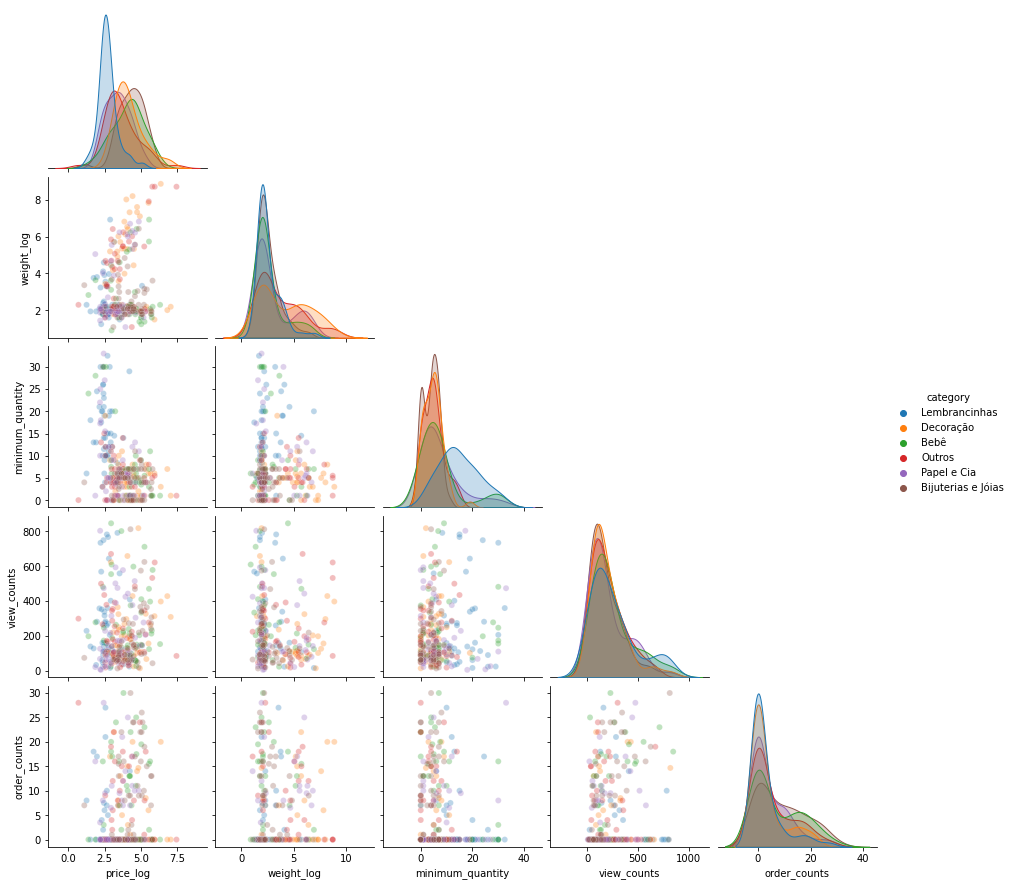

In [10]:
custom_pairplot_by_category(data=df,
                            col_list=col_list,
                            category="category",
                            sample_size=50)

Pelos histogramas das diagonais, boa parte dos padrões identificados pela
análise numérica puderam ser confirmados. As variáveis com maior relação com as
categorias são o preço, o peso e a quantidade mínima. 

As lembrancinhas em geral possuem custo e peso baixo, e ambos esses casos,
a quantidade mínima é alta. O que faz sentido, uma vez que pelo fato de o preço
unitário ser baixo, e ele ser leve (o que implica em um baixo custo marginal de
transporte) o custo fixo da transação é compensado por uma requerimento maior
de quantidades transacionadas.

Adicionalmente, para um grupo de produtos existe uma relação linear positiva
entre os logs do preço e peso. Com isso temos, que em média, para esses 
produtos, é esperado que aumentos percentuais de peso se transfiram em termos
percentuais para o preço (elasticidade peso/preço). Olhando pela amostra das
categorias vemos que isso está mais associada com alguns produtos de Bebê e
Decoração. Podemos hiptetizar que esses itens talvez sejam móveis, onde quanto
mais pesados, maior a quanlidade do material (madeira maciça vs mdf/mdp) e
maior o tamanho do produto.

## Explorando variáveis textuais

Para explorar as variáveis textuais vamos recorrer a processamento NLP e
redução de dimensionalidade para identificação de tópicos (dimensões latentes)
associadas aos textos.

Antes de decidir quais etapas de pré-processamento serão utilizadas, vamos
primeiro explorar os textos brutos. Para tal, serão utilizadas os métodos de
processamento textual padrão do pandas, para quebrar, listas e contabilizar
as frequências dos tokens. Os tokens são a menor unidade de análise da nossa
modelagem NLP. De forma simplificada cada palavra é um token.

Essa análise preliminar envolverá a análise dos tokens menos frequentes e dos
mais frequentes. A análise dos tokens menos frequentes será geral, evolvendo a
identificação do impacto da remoção de tokens pouco frequentes sobre o corpus.
Esse total será medido em termos de percetual de tokens únicos perdidos e
percentual de frequência de tokens perdida. Essas informações serão computados
por limiar de frequência mínima para remoção de tokens. Adicionalmente
também serão mostradas uma amostra de tokens cuja frequência é equivalente a
cada limiar.

A análise dos tokens mais frequentes é será realizada por categoria. São
selecionados os 15 tokens mais frequentes, e para cada categoria é realizado
um gráfico de barras da frequência relativa no categoria desses tokens. Com
isso, conseguimos fazer uma caracterização de cada categoria a partir de
seus tokens mais frequentes.

Essa análise será realizada para as colunas `title` e `concatenate_tags`.

In [11]:
def analyze_low_freq_tokens(tokens_freq: pd.Series) -> None:
    """Gera a tabela de corte de participaçòes de tokens por corte de
    frequência e o gráfico de linha com esses dados.

    Args:
        tokens_freq (pd.Series): série de frequência de tokens
    """    
    tokens_freq_total = tokens_freq.sum()
    n_tokens = tokens_freq.shape[0]
    # gerando os dados por nível de corte 1 - 10
    result_list = list()
    for min_freq in range(1, 11):
        min_freq_mask = tokens_freq <= min_freq
        n_tokens_select = min_freq_mask.sum()
        tokens_freq_select = tokens_freq[min_freq_mask].sum()
        selected_tokens = tokens_freq[tokens_freq == min_freq]
        sample_size = min(selected_tokens.shape[0], 5) 
        tokens_sample = selected_tokens.sample(sample_size).index.tolist()
        
        result = {"min_freq": min_freq,
                  "n_tokens_share": n_tokens_select / n_tokens,
                  "tokens_freq_share": tokens_freq_select / tokens_freq_total,
                  "token_sample": tokens_sample}
        result_list.append(result)
    
    # gerando o dataframe com os dados e visualizando o resultado
    min_freq_result = pd.DataFrame(result_list).set_index("min_freq")
    display(min_freq_result)
    # gerando os gráficos de linha
    plot_title = "Parcela da quantidade e frequência dos tokens por "\
                 "frequência mínima"
    (min_freq_result[["n_tokens_share", "tokens_freq_share"]].
     plot(subplots=True, figsize=(10.8, 5),
          title=plot_title))
    plt.show()

In [12]:

def analyze_high_freq_tokens_by_category(tokens: pd.Series,
                                         categories: pd.Series) -> None:
      """Faz o gráfico de barras dos tokens mais frequentes por categoria

      Args:
          tokens (pd.Series): série de tokens 
          categories (pd.Series): série de categorias
      """
      
      # contagem de top-15 tokens por categoria
      category_top_tokens = (tokens.to_frame("token").
                              join(categories).
                              groupby(categories.name).
                              apply(lambda x:
                                    x["token"].
                                    value_counts(normalize=True,
                                                 ascending=True).
                                    tail(15)).
                              reset_index())
      # renomear as colunas
      category_top_tokens.columns = ["category", "token", "category_share"]
      # criando os facets
      g = sns.FacetGrid(category_top_tokens, col="category",
                        col_wrap=3, height=4, sharey=False)
      # adicionando gráfico de barras ao grid
      g.map(plt.barh, "token",  "category_share")
      # criando o título
      g.fig.subplots_adjust(top=0.9)
      g.fig.suptitle("Frequência dos top tokens por categoria")
      plt.show()

In [13]:
def tokens_analysis(docs: pd.Series, categories: pd.Series) -> None:
    """Gera as visualizações para as análises respectivas aos tokens
    menos e mais frequentes.

    Args:
        docs (pd.Series): _description_
        categories (pd.Series): _description_
    """
    # gera os tokens
    tokens = docs.str.split().explode()
    print(f"Foram obtidos um total de {tokens.shape[0]} frequência de tokens")
    # frequência dos tokens no corpus
    tokens_freq = tokens.value_counts()
    print(f"Foram obtidos um total de {tokens_freq.shape[0]} tokens únicos")
    # gerando as visualizações de análise
    analyze_low_freq_tokens(tokens_freq=tokens_freq)
    analyze_high_freq_tokens_by_category(tokens, categories)

Foram obtidos um total de 102450 frequência de tokens
Foram obtidos um total de 12112 tokens únicos


,n_tokens_share,tokens_freq_share,token_sample
min_freq,,,
1,0.537401,0.063533,"[patinhas., hipoalergênica, Reciclado, Fim, Co..."
2,0.673629,0.095744,"[SMOKING, UNID., baton, Treliça, guardo]"
3,0.741083,0.119668,"[Colherzinha, Churrasqueira, OMBRO, TRADICIONA..."
4,0.785585,0.140713,"[Superman, Ovelhas, Ponteiras, LOUSA, (30]"
5,0.815885,0.158624,"[palitos, Odontologia, poderoso, Duas, olhos]"
6,0.838094,0.174378,"[Star, 7mm, Dourada, MULHER, Lisa]"
7,0.853864,0.187428,"[PLANNER, tags, Forma, (Arte, 38mm]"
8,0.869716,0.202421,"[pintado, EMBALAGEM, BORDADO, estojo, newborn]"
9,0.882348,0.215861,"[celular, cachorro, Térmica, Bichinhos, camisa]"


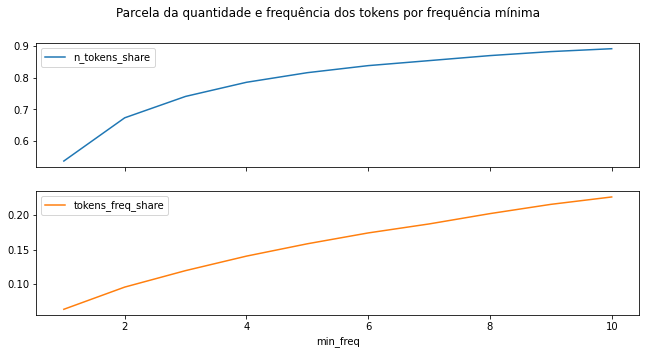

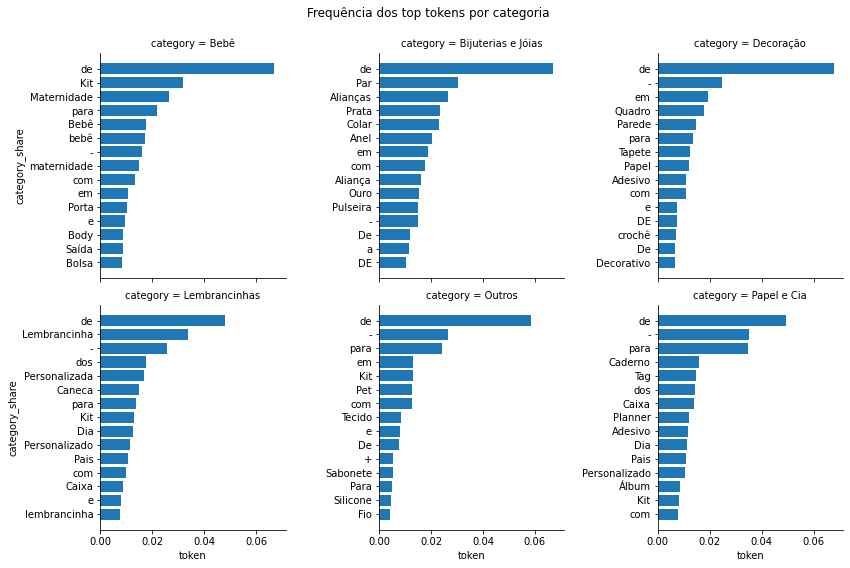

In [14]:
tokens_analysis(df["title"], df["category"])

Foram obtidos um total de 114956 frequência de tokens
Foram obtidos um total de 7173 tokens únicos


,n_tokens_share,tokens_freq_share,token_sample
min_freq,,,
1,0.404294,0.025227,"[amados, isys, sobrancelharia, boleira, reorga..."
2,0.549561,0.043356,"[cachepos, vagalume, porta-joias, vitto, lista1]"
3,0.630559,0.058518,"[jf, artesanto, rosana, rico, mitzvah]"
4,0.685487,0.072228,"[damas, conj.menina, resinas, vidrinhos, mm]"
5,0.722431,0.083754,"[folheada, polvo, tiago, bijus, rendado]"
6,0.746689,0.092836,"[vanessa, 03, fontes, alessandra, imperdiveis]"
7,0.767740,0.102030,"[lady, shop, marrom, mary, theozinho]"
8,0.785864,0.111077,"[pocoyo, paredes, manutencao, hello, danca]"
9,0.801896,0.120081,"[novidades, juliana, fortnite, jennefer, cimento]"


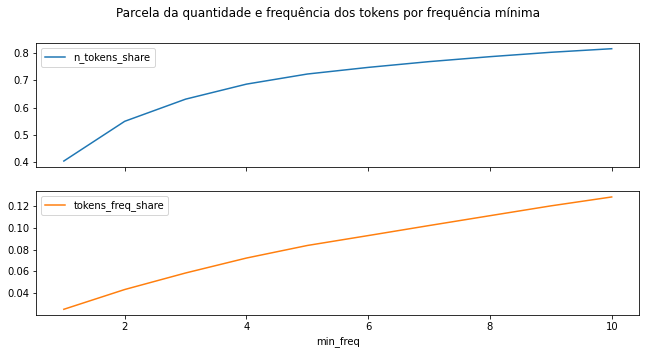

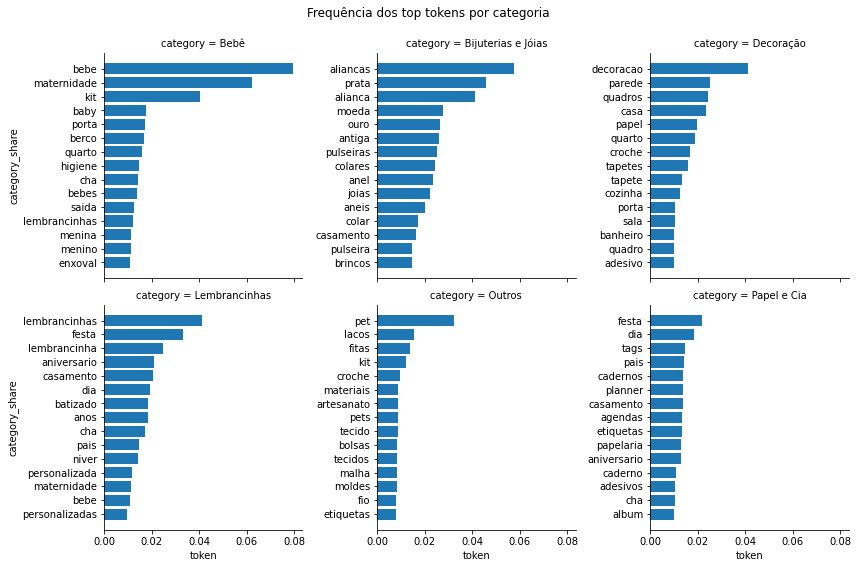

In [15]:
tokens_analysis(df["concatenated_tags"], df["category"])

A falta de padronização gera alguns problemas para a análise dos tokens.
Mantemos versões de uma mesma palavra, mas com alguma grafia diferente, mas o
correto seria contabilizar como sendo o mesmo token. Dessa forma, devemos
buscar eliminar essas variações.

Essa menor padronização é mais observada nos dados de título onde a grafia é
livre. No caso das tags, onde, aparentemente apenas texto em letra minúscula é
permitido, esse problema ocorre em um menor grau. Uma das consequências da
falta de padrão é o elevado percentual de tokens com baixa frequência, e a
maior participação destes, no total de frequência de tokens.

Um outro problema é dispersar a importância de certos tokens entre suas
variações. Com isso, deixamos de capturar relações entre palavras que
deveriam ser capturadas e capturamos outras que inexistem na realidade.
Adicionalmente, acabamos subestimando aqueles tokens que se encontram nos
documentos com múltiplos padrões de escrita.

Principalmente para os títulos temos vários tokens que não são palavras, ou que
são palavras que não agregam conteúdo para a classificação. Ou ainda, palavras
que são muito comuns e ocorrem em múltiplas categorias e com isso não auxiliam
na distinção entre as categorias.

Com o intuito de sanar esse problema devemos utilizar técnicas de
pré-processamento para tentar reduzir essas variabilidades no texto.

### Pré-processamento textual

Para pré-processar os textos vamos aplicar uma série de transformações com o
intuito de remover a variabilidade indesejada nos tokens e remover tokens que
não sejam importantes para a classificação.

Poderíamos tentar compor uma estratégia bastante particular através da análise
minuciosa nos dados. Porém vamos simplificar essa etapa e adotar uma estratégia
padrão. Primeiro vamos limpar os textos, removendo pontuação e os números do
texto. Em seguida vamos aplicar uma  tokenização customizada a partir da
bilioteca `nltk`. No processo de tokenização vamos remover as stopwords e os 
tokens cujo tamanho seja inferior a 2. Para reduzir a variabilidade ainda mais,
vamos utilizar a raiz da palavra (stem). Por fim, o texto é recodificado para
a codificação ASCII como forma de remover ascentos e caracteres especiais
da codificação UTF-8 (imagino que seja essa a codificação atual do texto).

Um dos problemas do stemming é que ao cortarmos a palavra, e mantermos apenas
o seu radical, muitas vezes deixamos de conseguir identificar o sentido do token.
Técnicas mais avançadas como a Lemmatização são capazes de padronizar os tokens
e ao mesmo manter o token em um formato reconhecível de palavra. Porém como o,
objetivo dessa etapa é aumentar a eficácia da utilização de variáveis textuais
para a classificação de produtos, nesse protótipo de solução vamos utilizar a
solução mais simples.

Para avaliar o impacto do pré-processamento vamos aplicar essas etapas e em
seguida fazer a mesma análise anterior que foi aplicada aos dados textuais
brutos para que os gráficos possam ser comparados.

In [16]:
def clean_text(text: str) -> str:
    """Realiza a limpeza do texto passando para o formato minúsculo e removendo
    caracteres indesejados.

    Args:
        text (str): texto a ser limpo

    Returns:
        str: texto limpo
    """    
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)

    return text

In [17]:
# https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
def remove_accents(text: str) -> str:
    """Remoção de ascentos e caracteres especiais

    Args:
        text (str): texto a ser processado

    Returns:
        str: texto sem ascento
    """    
    nfkd_form = unicodedata.normalize("NFKD", text)
    ascii_form = nfkd_form.encode("ASCII", "ignore").decode()
    return ascii_form

In [18]:
# instanciando a lista de stopwords
stopwords = nltk.corpus.stopwords.words("portuguese")
stopwords = [remove_accents(word) for word in stopwords]

# instanciando o stemmer do nltk para a língua portuguesa
stemmer = nltk.stem.RSLPStemmer()

def custom_tokenizer(text: str) -> list[str]:
    """Realiza a tokenizaçao customizada, composta por eliminação de stopwords
    e tokens curtos, stemming e remoção de ascentos.

    Args:
        text (str): texto a ser tokenizado

    Returns:
        list[str]: lista de tokens
    """    
    token_list = nltk.tokenize.word_tokenize(text=text, language="portuguese")
    stem_list = [stemmer.stem(token)
                 for token in token_list
                 if token not in stopwords and len(token) > 2]
    
    return [remove_accents(stem) for stem in stem_list]

In [19]:
def preprocess_text_serie(txt_serie: pd.Series) -> pd.Series:
    return (txt_serie.apply(clean_text).
            apply(custom_tokenizer).
            apply(lambda x: " ".join(x)))

Foram obtidos um total de 77699 frequência de tokens
Foram obtidos um total de 3599 tokens únicos


,n_tokens_share,tokens_freq_share,token_sample
min_freq,,,
1,0.373159,0.017285,"[giftbox, tequil, nem, estreit, arroz]"
2,0.495138,0.028585,"[gran, toqu, heart, floresc, casq]"
3,0.563490,0.038083,"[lais, monalis, balo, shu, part]"
4,0.614893,0.047607,"[vasc, carroc, rip, trip, macrame]"
5,0.654348,0.056745,"[bicol, desenh, costel, pioneir, aplic]"
6,0.683523,0.064853,"[orelh, nunc, jack, pinh, predi]"
7,0.706863,0.072420,"[prematur, multius, lantern, baralh, turc]"
8,0.726591,0.079731,"[oratori, man, chal, las, text]"
9,0.740761,0.085638,"[barril, and, elas, fir, eco]"


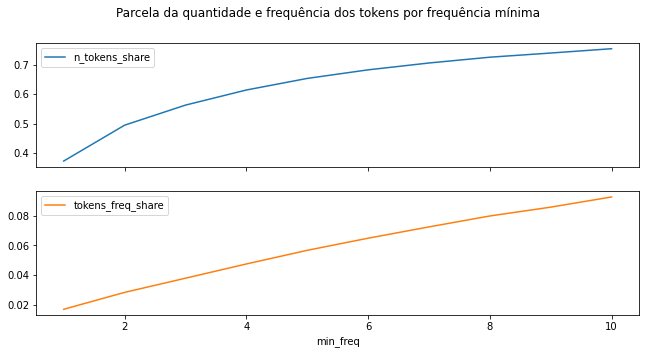

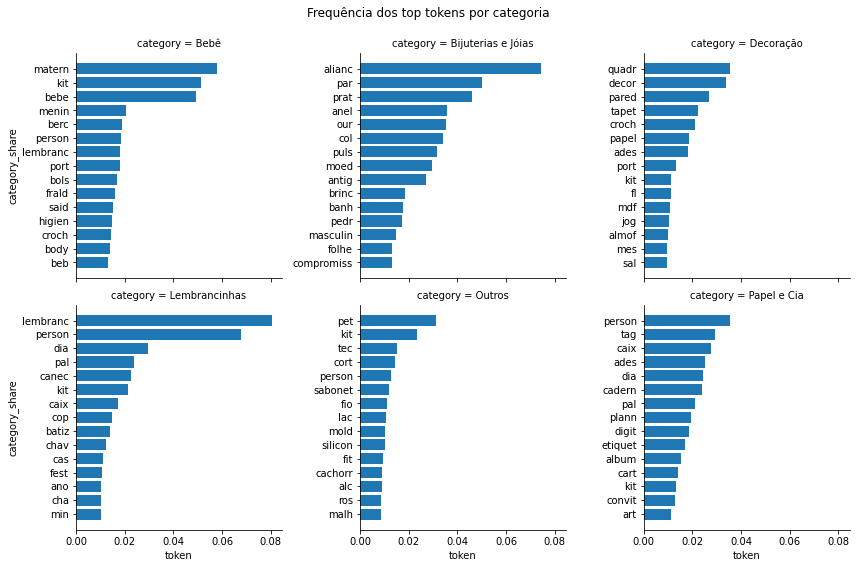

In [20]:
tokens_analysis(preprocess_text_serie(df["title"]), df["category"])

Foram obtidos um total de 111147 frequência de tokens
Foram obtidos um total de 4232 tokens únicos


,n_tokens_share,tokens_freq_share,token_sample
min_freq,,,
1,0.357987,0.013632,"[ramir, brennd, jonat, erik, squezz]"
2,0.491730,0.023817,"[esgot, bomb, bocal, scrub, connectiom]"
3,0.569471,0.032698,"[fred, arab, kat, braso, mija]"
4,0.622401,0.040760,"[ecol, gaby, joann, transport, revend]"
5,0.661153,0.048138,"[pca, cheir, expression, whisky, afes]"
6,0.686909,0.054023,"[ale, ranch, la, sobrancelh, aco]"
7,0.707467,0.059503,"[ballet, cat, isaqu, cili, pop]"
8,0.725662,0.065045,"[piercing, anthony, ani, bambin, pressa]"
9,0.744329,0.071443,"[gom, biomb, incri, projet, zen]"


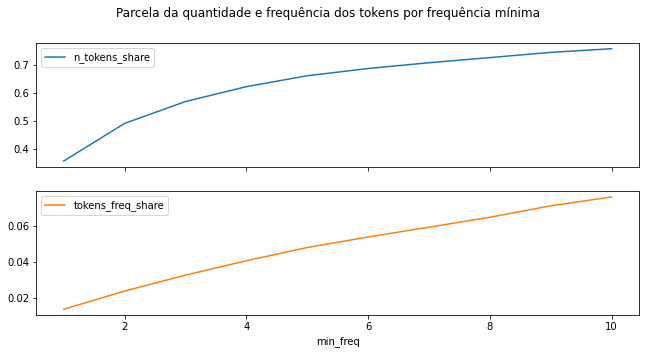

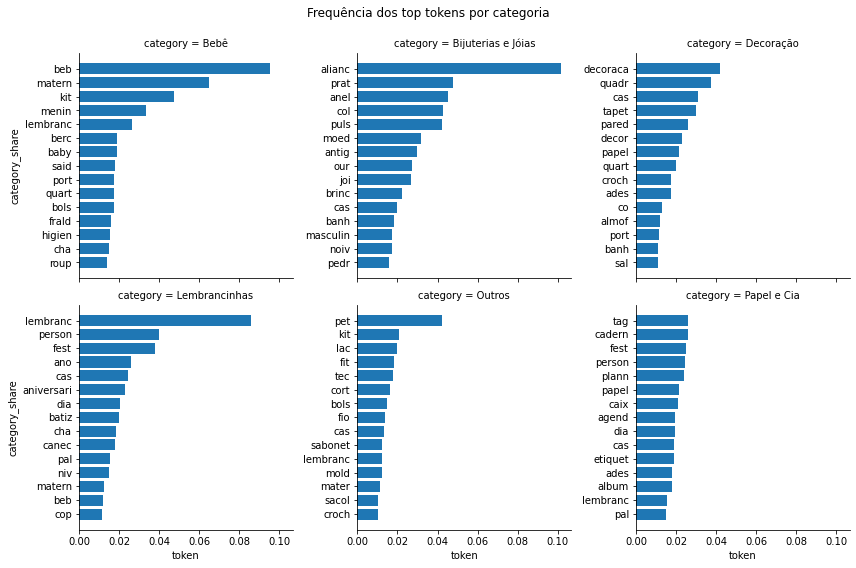

In [21]:
tokens_analysis(preprocess_text_serie(df["concatenated_tags"]), df["category"])

Com essas técnicas de pré-processamento vemos que houve uma melhora na
qualidade dos dados. Essa melhora é mais significativa para o caso do `title`.
Primeiro que foram removidos tokens que não agregavam sentido, como pontuações.
Segundo que a concentração das variações em torno de radicais padronizados,
melhorou a capacidade desses termos descreverem uma categoria, como no caso do
token beb (imagino referente a bebê) na categoria **Bebê** que é o terceiro
termo mais frequente, enquanto antes Bebê e bebê estavam na quarta e quinta
posição respectivamente.

Ainda, agora conseguimos identificar outros tokens que poderiam ser removidos
como stopwords. Não vamos fazer uma exploação mais detalhada nesse ponto,
mas de forma superficial conseguimos identificar o termo kit que pode ser
removido uma vez que ele está presente entre os top tokens para quase todas
as categorias.

In [22]:
# adicionando uma nova stopword
stopwords.append("kit")

### Modelagem de Tópicos

Definidas as etapas de pré-processamento falta agora definir a técnica de
redução de dimencionalidade para que seja possível utilizar as informações
dessas features para a modelagem de categorias de produtos.

A técnica de redução de dimensionalidade selecionada é a Non-Negative Matrix
Factorization (NMF). Essa técnica decompõe a matrix de features originais em
duas, uma de componentes por observações e outra de features por componentes.
No nosso caso, denominamos os componentes de tópicos, e conceitualmente podem
ser considerados com dimensões latentes originadas das associações entre as
palavras de um determinado conjunto de textos. A única condição para aplicar
essa técnica é que a matriz de features seja não negativa, o que é o casa
para técnicas de vetorização de documentos (no caso utilizamos TF-IDF que
combinação frequência do token com o inverso da frequência de documentos que
o token é presente).

Uma vantagem da utilização de NMF é que as quantidades obtidas dos pesos dos
componentes também são todas positivas. Com isso fica mais fácil de interpretar
esse resultado como sendo a importância do tópico para um documento. O mesmo
vale para a matriz de componentes por tokens.

Para analisar a aplicação dessas técnicas para a caracterização dos tópicos
vamos primeiro identificar os termos mais relevantes para cada tópico. Em,
seguida a distribuição dos pesos de cada componente por categorias, dispostos
em um boxplot.

Isso será realizado para as duas variáveis textuais. Como o objetivo é
ilustrativo, o NMF será executado com apenas 6 componentes. A vetorização por
TF-IDF irá incorporar as funções de pré-processamento textual e tokenização
desenvolvidas na etapa anterior.

In [23]:
def show_top_words(topic_model, tfidf_vec, n_words=10):
    """Visualização dos top tokens por componente do NMF

    Args:
        topic_model (_type_): modelo NMF treinado
        tfidf_vec (_type_): objeto vetorizador TF-IDF
        n_words (int, optional): número de top tokens. Defaults to 10.
    """
    for i, component in enumerate(topic_model.components_):
        top_words_ids = list(component.argsort()[:-n_words - 1: -1])
        top_words_list = tfidf_vec.get_feature_names_out()[top_words_ids]
        print(f"Topic {i} - {' | '.join(top_words_list)}")


def explore_topics(doc, by, n_components):
    """Faz a análise dos tópicos de NMF por categoria

    Args:
        doc (_type_): variável textual
        by (_type_): variável categórica
        n_components (_type_): quantidade de tópicos
    """    
    tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer,
                                preprocessor=clean_text)
    tfidf_data = tfidf_vec.fit_transform(doc)
    topic_model = NMF(n_components=n_components, init="random")
    topic_data = topic_model.fit_transform(tfidf_data)
    show_top_words(topic_model=topic_model, tfidf_vec=tfidf_vec)
    
    topics_df = pd.DataFrame(topic_data, index=doc.index).join(by)
    topics_df.boxplot(column=list(range(n_components)),
                      by=by.name,
                      showfliers=False,
                      figsize=(15, 10))
    plt.show()

Topic 0 - lembranc | cas | ano | cha | aniversari | aromatiz | nasc | matern | sabonet | min
Topic 1 - batiz | caix | padr | menin | convit | toalh | lembranc | anj | vel | mdf
Topic 2 - person | canec | cop | sacol | canet | almof | lat | chav | fest | necessa
Topic 3 - matern | port | bols | said | menin | pec | saqu | enfeit | urs | mal
Topic 4 - dia | pal | canec | profes | pres | caix | chav | chinel | pai | port
Topic 5 - bebe | croch | cha | tapet | decor | quadr | menin | pared | higien | co


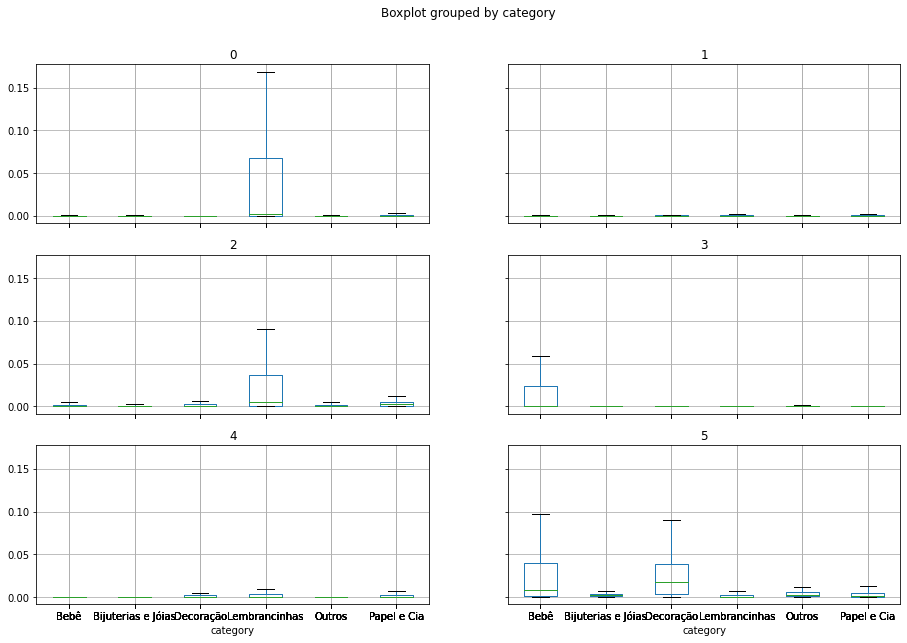

In [24]:
explore_topics(df["title"], df["category"], 6)

Utilizando 6 componentes para o NMF dos títulos, os componentes 0 e 1 parecem
ter se especializado em reconhecer padrões nos textos referentes à categoria
de lembrancinhas. Ambos esses tópicos possuem entre seus tokens mais
importantes, tokens como lembrança, caneca, caixa, chá... (deduzidos a partir
dos tokens pré-processados). O tópico 3 por sua vez parece ser capaz de
identificar os tópicos de decoração (parede, decor, papel, quadro...). Já os
tópicos 2 e 5 tendem a se especializar mais na categoriza bebê (bebê,
maternidade, croche, saída...). O tópico quatro não parece ser claro a
identificação, mas talvez ele tenha atributos relacionados à categoria Papel e
Cia.

Topic 0 - lembranc | aniversari | fest | matern | ano | cas | nasc | cha | niv | chav
Topic 1 - person | canec | cop | sacol | fest | canet | almof | ano | aniversari | chinel
Topic 2 - cas | decoraca | tapet | quadr | pared | papel | croch | decor | ades | quart
Topic 3 - beb | matern | cha | menin | said | port | bols | baby | frald | quart
Topic 4 - batiz | caix | bat | menin | padr | toalh | convit | comunha | nasc | canec
Topic 5 - dia | pal | profes | canec | mae | chinel | pres | namor | sandal | quadr


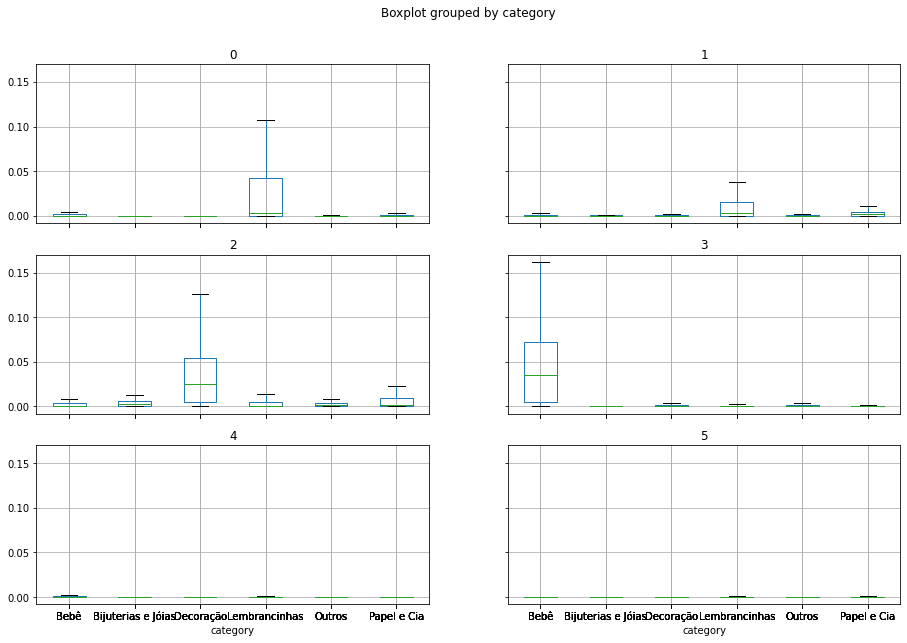

In [25]:
explore_topics(df["concatenated_tags"], df["category"], 6)

Assim como ocorreu no caso dos títulos, quando aplicamos a mesma análise para
o caso das tags, vemos resultado similar, onde os componentes conseguem
aprender padrões contidos nos dados de tokens e esses padrões parecem ser úteis
para a identificação de categorias.

Outro ponto similar que vale notar, é que apenas as categorias cuja frequência
na amostra são maiores é que são mais fáceis de serem identificadas. As outras
três, talvez pela falta de quantidade de observações são mais difícieis de
serem identificadas.

# Conclusão

Como resultado dessa análise identificamos uma variável categórica
`express_delivery` e três variáveis numéricas `price`, `weight` e
`minimum_quantiy` que podem ser utilizadas para prever as categorias dos
produtos. Adicionalmente desenvolvemo um método baseado em, limpeza e
tokenização de textos, TF-IDF de tokens e NMF de TF-IDF para gerar novas
features, tópicos, que podem ser extraídas das colunas `title` e
`concatenated_tags`, e podem contribuir para a classificação de produtos em
tópicos.